In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Finding Structural Simiarity
Created on Sun Sep 12 23:47:57 2021

@author: Junho John Song
"""

from tqdm import tqdm

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import torch

from skimage.metrics import structural_similarity as ssim

In [2]:
adda = sc.read_h5ad('./data/smaller_dada.h5ad')

In [3]:
adda.shape

(2597, 1500)

In [4]:
gene_names = adda.var.index.tolist()
row_col = adda.obs[['array_row', 'array_col']].values.astype(int)
df = pd.DataFrame(data=np.concatenate((row_col, adda.X), axis=1), columns=['row', 'col'] + gene_names)
df['row'] = df['row'].astype(int)
df['col'] = df['col'].astype(int)

In [6]:
def min_max_scale(gm):
    not_nan_values = gm[~np.isnan(gm)]
    mx = not_nan_values.max()
    mn = not_nan_values.min()
    gm = gm - mn
    gm = gm / (mx - mn)
    return gm

def make_gene_map(gene_df, gene_name):
    gm = min_max_scale(gene_df.pivot('row', 'col', gene_name).values)
    gm[np.isnan(gm)] = 0
    return gm

row_len = row_col[:, 0].max() - row_col[:, 0].min() + 1
col_len = row_col[:, 1].max() - row_col[:, 1].min() + 1
gene_maps = np.zeros([len(gene_names), row_len, col_len], dtype=np.float32)
for i, name in enumerate(gene_names):
    gene_maps[i] = make_gene_map(df, name)

In [ ]:
data = gene_maps
data1 = gene_maps[gene_names.index('Calml4')]

plt.imshow(data1)
plt.show()

In [6]:
def find_similar_genes(target_feat, all_features, top_k=10):
    dist = [-1 * ssim(target_feat, all_features[i]) for i in range(all_features.shape[0])]
    top_k_idx = np.argsort(dist)[1:top_k+1]
    return top_k_idx

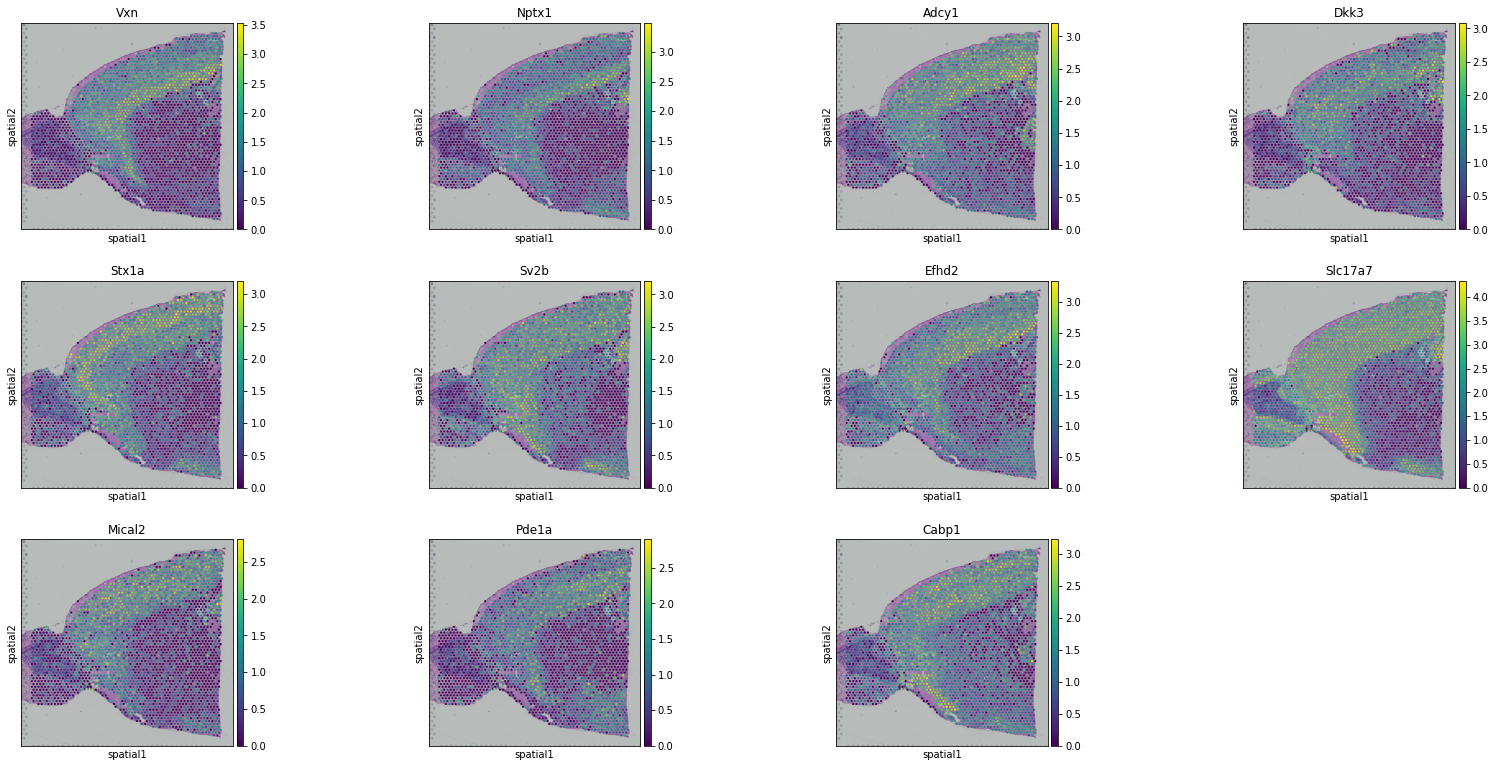

In [39]:
target_gene_name = 'Vxn'
target_gene_idx = gene_names.index(target_gene_name)
top10_genes = find_similar_genes(gene_maps[target_gene_idx], gene_maps)

sc.pl.spatial(adda, color=[target_gene_name] + [gene_names[i] for i in top10_genes])

(0.0, 1.0)

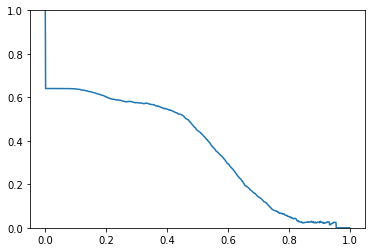

In [ ]:
plt.plot(x, jaccard_mean)
plt.ylim([0, 1])

In [ ]:
np.mean(jaccard_auc_list)

0.364531756980732

(0.0, 1.0)

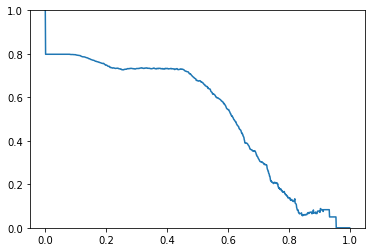

In [ ]:
plt.plot(x, precision_mean)
plt.ylim([0, 1])

In [ ]:
np.mean(precision_auc_list)

0.5148541674312652

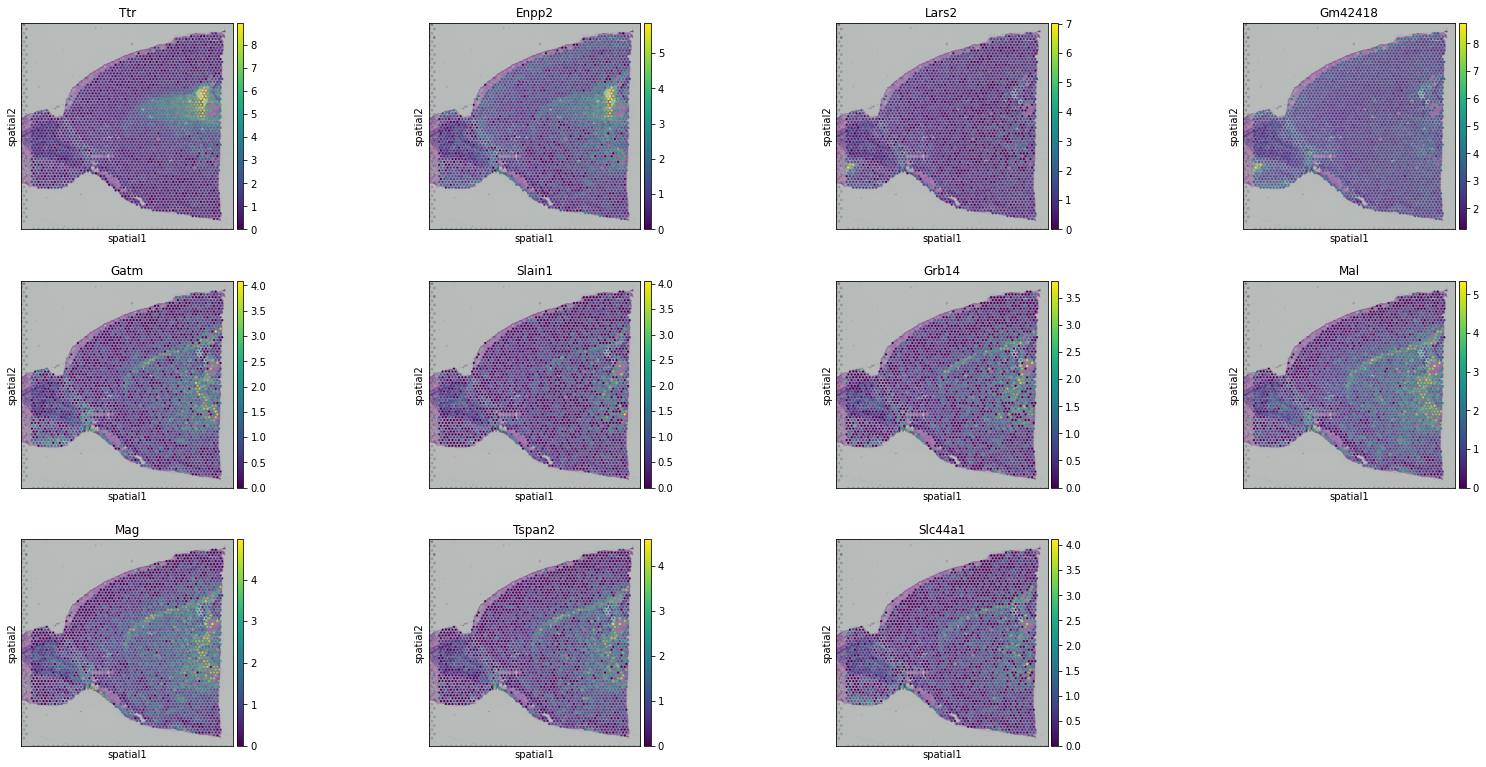

In [8]:
target_gene_name = 'Ttr'
target_gene_idx = gene_names.index(target_gene_name)
top10_genes = find_similar_genes(gene_maps[target_gene_idx], gene_maps)

sc.pl.spatial(adda, color=[target_gene_name] + [gene_names[i] for i in top10_genes])

## Jaccard & Precision measurement

In [46]:
def jaccard_precision_recall(gt, pred, threshold=0.5):
    assert gt.max() <= 1 and gt.min() >= 0
    assert pred.max() <= 1 and pred.min() >= 0
    assert threshold <= 1 and threshold >= 0
    assert gt.shape[0] == pred.shape[0]
    assert gt.shape[1] == pred.shape[1]

    gt = (gt >= threshold)
    pred = (pred >= threshold)
    
    inter = (gt & pred).sum()
    gt_area = gt.sum()
    pred_area = pred.sum()
    union = gt_area + pred_area - inter
    
    if union > 0:
        jaccard = inter / union
    else:
        jaccard = 0
    if pred_area > 0:
        precision = inter / pred_area
    else:
        precision = 0
    return jaccard, precision

def jaccard_precision_curve(gt, pred, threshold_num=1000):
    threshold_list = []
    jaccard_list = []
    precision_list = []
    for th in np.linspace(0, 1, threshold_num):
        threshold_list.append(th)
        j, p = jaccard_precision_recall(gt, pred, th)
        jaccard_list.append(j)
        precision_list.append(p)

    return threshold_list, jaccard_list, precision_list


In [45]:
target_gene_name = 'Vxn'
target_gene_idx = gene_names.index(target_gene_name)
# top10_genes = find_similar_genes(all_features[target_gene_idx], all_feats)

In [13]:
import os
from tqdm import tqdm

import hydra
import numpy as np
from omegaconf import OmegaConf as OC
import pandas as pd
import scanpy as sc
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as D

import dataset as DAT
import tools as T
import tools.modules
import tools.sklearn

In [34]:
# Load config
os.getcwd()
PROJECT_DIR = '/zdisk/jaesungyoo/spatial_gene'
# PROJECT_DIR = '/home/jaesungyoo/spatial_gene'
os.chdir(PROJECT_DIR)
os.listdir()

hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize_config_dir(config_dir=os.path.join(PROJECT_DIR, 'conf'), job_name='debug')
overrides = []
cfg = hydra.compose(config_name='l_regression', overrides=overrides)
print(OC.to_yaml(cfg))

path:
  project: /zdisk/jaesungyoo/spatial_gene
  data: ${path.project}/data/smaller_dada.h5ad
  bsc: ${path.project}/data/bsc.txt
train:
  lr: 0.0001
  batch_size: 128
  epoch: 100
random:
  seed: 0
model:
  n_features: 128
split:
  train: 0.8
  val: 0.1
  test: 0.1



In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [36]:
l_model_features = np.zeros([len(gene_names), cfg.model.n_features], dtype=np.float32)
# model.eval()
# for i in range(len(gene_names)):
#     x = torch.tensor(np.expand_dims(gene_maps[i], [0, 1])).to(device)
#     with torch.no_grad():
#         l_model_features[i] = model(x)[0].cpu().numpy()

In [42]:
target_gene_name = 'Vxn'
target_gene_idx = gene_names.index(target_gene_name)
top10_genes, l_values = find_similar_genes(l_model_features[target_gene_idx], l_model_features)
gt = gene_maps[target_gene_idx]
jaccard_auc_list = []
precision_auc_list = []
threshold_num = 1000
jaccard_sum = np.zeros([threshold_num])
precision_sum = np.zeros([threshold_num])


ValueError: too many values to unpack (expected 2)

In [43]:

for i in top10_genes:
    pred = gene_maps[i]
    x, j, p = jaccard_precision_curve(gt, pred, threshold_num)
    jaccard_auc_list.append(metrics.auc(x, j))
    precision_auc_list.append(metrics.auc(x, p))
    
    jaccard_sum += j
    precision_sum += p

    plt.figure()
    plt.plot(x, j)
    plt.plot(x, p)
    plt.plot([0, 1], [1, 0])
    plt.show()


NameError: name 'metrics' is not defined

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

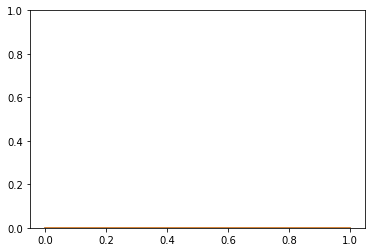

In [44]:
    
jaccard_mean = jaccard_sum / len(top10_genes)
precision_mean = precision_sum /len(top10_genes)
plt.plot(x, jaccard_mean)
plt.ylim([0, 1])
np.mean(jaccard_auc_list)
plt.plot(x, precision_mean)
plt.ylim([0, 1])
np.mean(precision_auc_list)
